In [109]:
import numpy as np
import matplotlib.pyplot as plt
from knn import KNNCalibrator   # import your calibrator (adjust path if needed) # from pyuncertainnumber.calibration.knn import KNNCalibrator
rng = np.random.default_rng(12)

def paraboloid_model(theta, xi=0.0, A=1.0, B=0.5, C=1.5):
    """Vectorized paraboloid, mild noise; supports scalar or vector xi."""
    theta = np.atleast_2d(theta).astype(float)
    x1, x2 = theta[:, 0], theta[:, 1]
    xi = np.asarray(xi, float)
    if xi.ndim == 0:
        xi = np.full(theta.shape[0], xi)
    elif xi.ndim == 2:
        xi = xi.ravel()
    y = A * x1**2 + B * x1 * x2 * (1.0 + xi) + C * (x2 + xi) ** 2
    y = y + 0.2 * np.random.randn(theta.shape[0])  # small noise
    return y.reshape(-1, 1) if theta.shape[0] > 1 else np.array([y.item()])

def theta_sampler(n, lb=-15, ub=15):
    return np.random.uniform(lb, ub, size=(n, 2))

def scatter_post(ax, theta, truth=None, title="", alpha=0.30, s=6, label="Posterior"):
    ax.scatter(theta[:,0], theta[:,1], s=s, alpha=alpha, label=label)
    if truth is not None:
        ax.scatter(truth[:,0], truth[:,1], c="r", marker="x", s=60, label="θ true cloud")
    ax.set_title(title); ax.set_xlabel("θ1"); ax.set_ylabel("θ2"); ax.grid(True); ax.legend()


Generate empirical evidence (data from an unknown data gen process)

* Case 1 - 1 sample (y), 1 target (θ point-valued), 1 experiment (ξ)
* Case 2 - 100 sample (y) from 100 targets (θ distribution), 1 experiment (ξ)
* Case 3 - 100 sample (y) from 100 targets (θ distribution), for 4 experiments (ξ)


In [110]:
# generate data for the horse and pony show

# Case 1 - 1 sample (y), 1 target (θ point-valued), 1 experiment (ξ)
theta_true_c1 = rng.normal(0, 4, size=(1, 2))   # unknown
xi_list_c1 = [0.0]  # selected (experiment)
y_emp = paraboloid_model(theta_true_c1, xi_list_c1)
observations_c1 = [(y_emp, xi_list_c1)]
print(f"CASE 1 - designs: {len(observations_c1)} samples: {observations_c1[0][0].shape[0]}")

# Case 2 - 100 sample (y) from 100 targets (θ distribution), 1 experiment (ξ)
N_emp = 100
xi_list_c2 = xi_list_c1
theta_true_cloud = rng.normal(4.0, 0.5, size=(N_emp, 2))   # unknown
y_emp= paraboloid_model(theta_true_cloud, xi_list_c1)
observations_c2 = [(y_emp, xi_list_c1)]

print(f"CASE 2 - designs: {len(observations_c2)} samples: {observations_c2[0][0].shape[0]}")

# Case 3 - 100 sample (y) from 100 targets (θ distribution), for 4 experiments (ξ)
xi_list_c3 = [-1.0, 0.0, 1.0, 3.0]
observations_c3 = []
for xi in xi_list_c3:
    y_emp  = paraboloid_model(theta_true_cloud, xi)  # shape (100,1) per design
    observations_c3.append((y_emp, xi))

print(f"CASE 3 - designs: {len(observations_c3)} samples: {observations_c3[0][0].shape[0]}")


CASE 1 - designs: 1 samples: 1
CASE 2 - designs: 1 samples: 100
CASE 3 - designs: 4 samples: 100


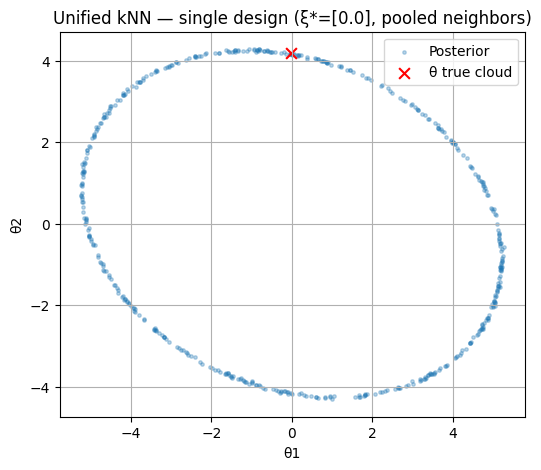

In [111]:
# set up knn calibrator
calib_single = KNNCalibrator(knn=500, evaluate_model=True)
calib_single.setup(model=paraboloid_model,
                   theta_sampler=theta_sampler,
                   xi_list=xi_list_c1, n_samples=500_000)
# run calibration
post_single = calib_single.calibrate(observations=observations_c1, combine="stack")  # pooled kNN
theta_post_single = post_single["theta"]
# visualize
fig, ax = plt.subplots(figsize=(6,5))
scatter_post(ax, theta_post_single, truth=np.atleast_2d(theta_true_c1),
             title=f"Unified kNN — single design (ξ*={xi_list_c1}, pooled neighbors)")
plt.show()

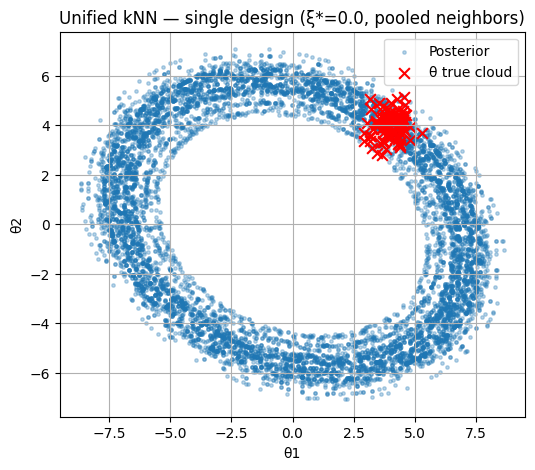

In [112]:
# set up knn calibrator
xi_star = 0.0
y_obs_star = next(y for (y, x) in observations_c2 if np.isclose(x, xi_star))

calib_single = KNNCalibrator(knn=100, evaluate_model=True)
calib_single.setup(model=paraboloid_model, theta_sampler=theta_sampler, xi_list=[xi_star], n_samples=100_000)
# run calibration
post_single = calib_single.calibrate([(y_obs_star, xi_star)], combine="stack")  # pooled kNN
theta_post_single = post_single["theta"]
# visualize
fig, ax = plt.subplots(figsize=(6,5))
scatter_post(ax, theta_post_single, truth=theta_true_cloud,
             title=f"Unified kNN — single design (ξ*={xi_star}, pooled neighbors)")
plt.show()

Reuse precomputed simulations (evaluate_model=False)

Build one big (θ, ξ) pool, then filter by ξ* to create per-design kNN indices


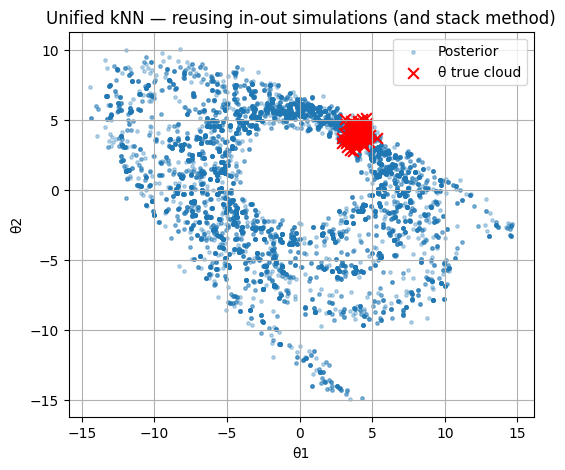

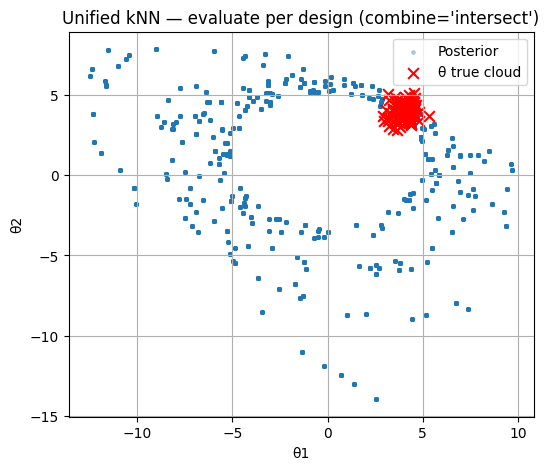

In [113]:

N_SIM = 1_000_000
knn = 10
resample_n = 10000

theta_sim_pool = theta_sampler(N_SIM)
xi_sim_pool = rng.uniform(-4, 4, size=(N_SIM, 1))
y_sim_pool = paraboloid_model(theta_sim_pool, xi_sim_pool)

simulated_data = {"y": y_sim_pool, "theta": theta_sim_pool, "xi": xi_sim_pool}
# 'prep model
calib_comb = KNNCalibrator(knn=knn, evaluate_model=False, a_tol=0.05)
calib_comb.setup(simulated_data=simulated_data, xi_list=xi_list_c3)


# 'vote' = stack
post_reuse = calib_comb.calibrate(observations_c3, combine="stack", resample_n=resample_n)
theta_post_reuse = post_reuse["theta"]

fig, ax = plt.subplots(figsize=(6,5))
scatter_post(ax, theta_post_reuse, truth=theta_true_cloud,
             title="Unified kNN — reusing in-out simulations (and stack method)")
plt.show()


# 'vote' = intersect
post_eval_vote = calib_comb.calibrate(observations_c3, combine="intersect", resample_n=resample_n)
theta_post_vote = post_eval_vote["theta"]

fig, ax = plt.subplots(figsize=(6,5))
scatter_post(ax, theta_post_vote, truth=theta_true_cloud,
             title="Unified kNN — evaluate per design (combine='intersect')")
plt.show()


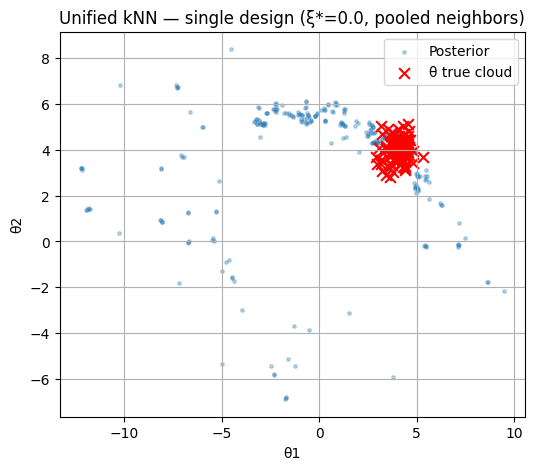

In [114]:

post = calib_comb.calibrate(
    observations_c3,
    combine="intersect",
    resample_n=None,          # <-- keep full weighted set
    combine_params={
                "theta_match_tol": 1e-3,
                "min_frac": 0.0,      # min occurrence fraction
                "gamma": 0.2,         # frequency sharpening
                "use_kde": True,      # enable KDE reweighting
                "kde_bw": 0.2
    }
)

theta_post = post["theta"]
w_post     = post.get("weights", None)   # now you have KDE weights too


# visualize
fig, ax = plt.subplots(figsize=(6,5))
scatter_post(ax, theta_post[w_post>np.quantile(w_post,0.9),:], truth=theta_true_cloud,
             title=f"Unified kNN — single design (ξ*={xi_star}, pooled neighbors)")
plt.show()


Per-design overlay

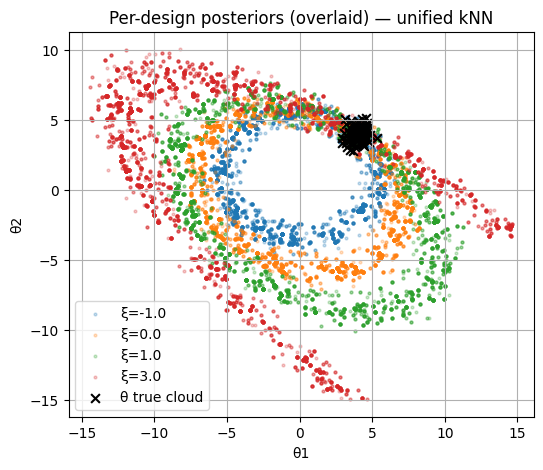

In [115]:
fig, ax = plt.subplots(figsize=(6,5))
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
for c, xi in zip(colors, xi_list_c3):
    post_xi = calib_comb.calibrate([(next(y for (y,x) in observations_c3 if np.isclose(x, xi)), xi)],
                                   combine="stack", resample_n=5000)
    th_xi = post_xi["theta"]
    ax.scatter(th_xi[:,0], th_xi[:,1], s=4, alpha=0.25, label=f"ξ={xi}", c=c)
ax.scatter(theta_true_cloud[:,0], theta_true_cloud[:,1], c="k", marker="x", s=40, label="θ true cloud")
ax.set_title("Per-design posteriors (overlaid) — unified kNN")
ax.set_xlabel("θ1"); ax.set_ylabel("θ2"); ax.grid(True); ax.legend()
plt.show()

In [116]:
from scipy.stats import gaussian_kde
posters = []
for xi in xi_list_c3:
    y_i = next(y for (y,x) in observations_c3 if np.isclose(x, xi))
    post_i = calib_comb.calibrate([(y_i, xi)], combine="stack", resample_n=1000)
    posters.append((xi, post_i["theta"]))

stack_all = np.vstack([th for _, th in posters] + [theta_true_cloud])
x_min, x_max = np.percentile(stack_all[:,0], [1, 99])
y_min, y_max = np.percentile(stack_all[:,1], [1, 99])
nx, ny = 200, 200
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                     np.linspace(y_min, y_max, ny))
grid = np.vstack([xx.ravel(), yy.ravel()])

zz = np.zeros((ny, nx))
for (c, (xi, th_xi)) in zip(colors, posters):
    kde = gaussian_kde(th_xi.T, bw_method='scott') # KDE on the posterior samples of this design
    zz_grid = kde(grid).reshape(ny, nx)
    zz += np.log(zz_grid)

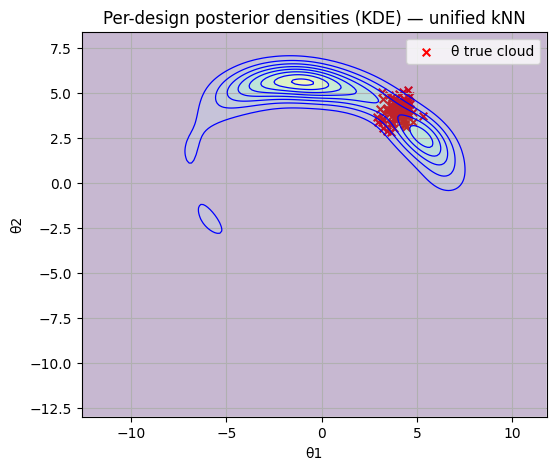

In [117]:

fig, ax = plt.subplots(figsize=(6,5))
# filled contours + a thin outline
zz_lik = np.exp(zz)

# true cloud on top
ax.scatter(theta_true_cloud[:,0], theta_true_cloud[:,1],
           c="r", marker="x", s=30, label="θ true cloud")

csf = ax.contourf(xx, yy, zz_lik, levels=8, alpha=0.3, antialiased=True)
ax.contour(xx, yy, zz_lik, levels=8, colors='b', linewidths=0.9)

ax.set_title("Per-design posterior densities (KDE) — unified kNN")
ax.set_xlabel("θ1"); ax.set_ylabel("θ2"); ax.set_xlim(x_min, x_max); ax.set_ylim(y_min, y_max)
ax.grid(True); ax.legend()
plt.show()


In [118]:
# EXAMPLE: NASA-like
import numpy as np

# --- NASA-like synthetic model: θ = [xa1, xa2, xe1, xe2, xe3], xi ∈ R^3 → y ∈ R^6  ---
def nasa_synthetic_model(theta, xi=None, noise=True):
    """  Vectorized toy model with NASA-like dimensions """
    theta = np.atleast_2d(theta).astype(float)
    n = theta.shape[0]
    xa1, xa2, xe1, xe2, xe3 = theta.T
    if xi is None:
        xi = np.zeros((n, 3))
    else:
        xi = np.atleast_2d(xi).astype(float)
        if xi.shape[0] == 1 and n > 1:  # broadcast one design to all theta
            xi = np.repeat(xi, n, axis=0)
    xc1, xc2, xc3 = xi.T

    # 6 KPIs (nonlinear & mixed terms)
    y1, y2 = xa1**2 + xe1 + np.sin(xc1),              xa2 * xe2 + np.cos(xc2)
    y3, y4 = xe3**2 - xa1*xa2 + np.tanh(xc3),         xa1 + xa2 + xe1*xe2
    y5, y6 = -0.1*(xe2+xc1) + xa1*xc2,                np.abs(xa2+xe3) + xc3
    Y = np.column_stack([y1, y2, y3, y4, y5, y6])

    if noise:
        Y += 0.05 * np.random.randn(*Y.shape)
    return Y if n > 1 else Y[0]

low_xa, up_xa = -10.0, 10.0
low_xe, up_xe = -10.0, 10.0
low_xc, up_xc = -1.0, 1.0
def theta_sampler_uniform(n, xa_bounds=(low_xa, up_xa), xe_bounds=(low_xe, up_xe), rng=None):
    rng = np.random.default_rng(None) if rng is None else rng
    xa = rng.uniform(xa_bounds[0], xa_bounds[1], size=(n, 2))
    xe = rng.uniform(xe_bounds[0], xe_bounds[1], size=(n, 3))
    return np.hstack([xa, xe])

# -------------------- DATA GENERATION --------------------
# 1) Build 100 θ-samples: first two (xa) from a distribution, last three (xe) fixed
# 2) Ten designs (xi_list ∈ R^{10×3})
# 3) For each design, generate a dataset of 100 observations (6 KPIs each)
rng = np.random.default_rng(23)
ns = 100
xe_true = np.array([3, 2, -4.0])                    # fixed epistemic part (xe)
xe_true = np.clip(xe_true, low_xe, up_xe )
xa_sam1 = rng.multivariate_normal(  mean=[3, -2],  cov=[[1, 0.9],     [0.9, 1]],   size=(20, ) )
xa_sam2 = rng.multivariate_normal(  mean=[-3, -0],  cov=[[1, -0.5],     [-0.5, 1]],   size=(ns-20, ) )
xa_samples = np.vstack([xa_sam1,xa_sam2] )
xa_samples = np.clip(xa_samples,low_xa, up_xa)
theta_samples = np.hstack([xa_samples, np.tile(xe_true, (ns, 1))])  # (100,5)


xi_list = rng.uniform(low=low_xc, high=up_xc, size=(10, 3)).round(2)             # (10,3)
xi_list = np.clip(xi_list,low_xc, up_xc)
xi_list = xi_list.tolist()  # ✅ Convert to list-of-lists so the calibrator sees it cleanly

datasets = []
for xi in xi_list: # [(Y^(1), xi_1), ..., (Y^(10), xi_10)]
    Y = nasa_synthetic_model(theta_samples, xi, noise=True)        # (100,6)
    datasets.append((Y, xi))


In [120]:
from knn import estimate_p_theta_knn

posters = []
for (y_obs_i, design_i) in datasets:

    n = 120_000
    theta_sim_i = theta_sampler_uniform(n, rng=rng)  # sim theta
    design_sam_i = rng.uniform(low=np.array(design_i)-0.01, high=np.array(design_i)+0.01, size=(n, 3)).round(2)   # sim design around i-th in the list

    y_sim_i = nasa_synthetic_model(theta_sim_i, design_sam_i, noise=True)

    simulated_data = [np.array(y_sim_i), np.array(theta_sim_i), np.array(design_sam_i) ] # list of arrays, [y, θ, ξ],

    post_i = estimate_p_theta_knn(observed_data = y_obs_i,
                                  simulated_data = simulated_data,
                                  knn=10,
                                  xi_star=np.array(design_i),
                                  a_tol=0.1)

    posters.append((design_i, post_i))


In [121]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Flatten posters into a tidy DataFrame
records = []
for id, (d, post) in enumerate(posters):
    for row in post[:500]:   # take first 500 posterior samples
        rec = {f"theta{i+1}": row[i] for i in range(post.shape[1])}
        rec["design"] = f"design {id}"   # group label
        rec["calibrated"] = "calibrated"
        records.append(rec)

df = pd.DataFrame(records)

# Create a DataFrame for theta_samples (targets)
df_targets = pd.DataFrame(theta_samples, columns=[f"theta{i+1}" for i in range(theta_samples.shape[1])])
df_targets["design"] = "target"
df_targets["calibrated"] = "target"

# Combine
df_full = pd.concat([df, df_targets], ignore_index=True)



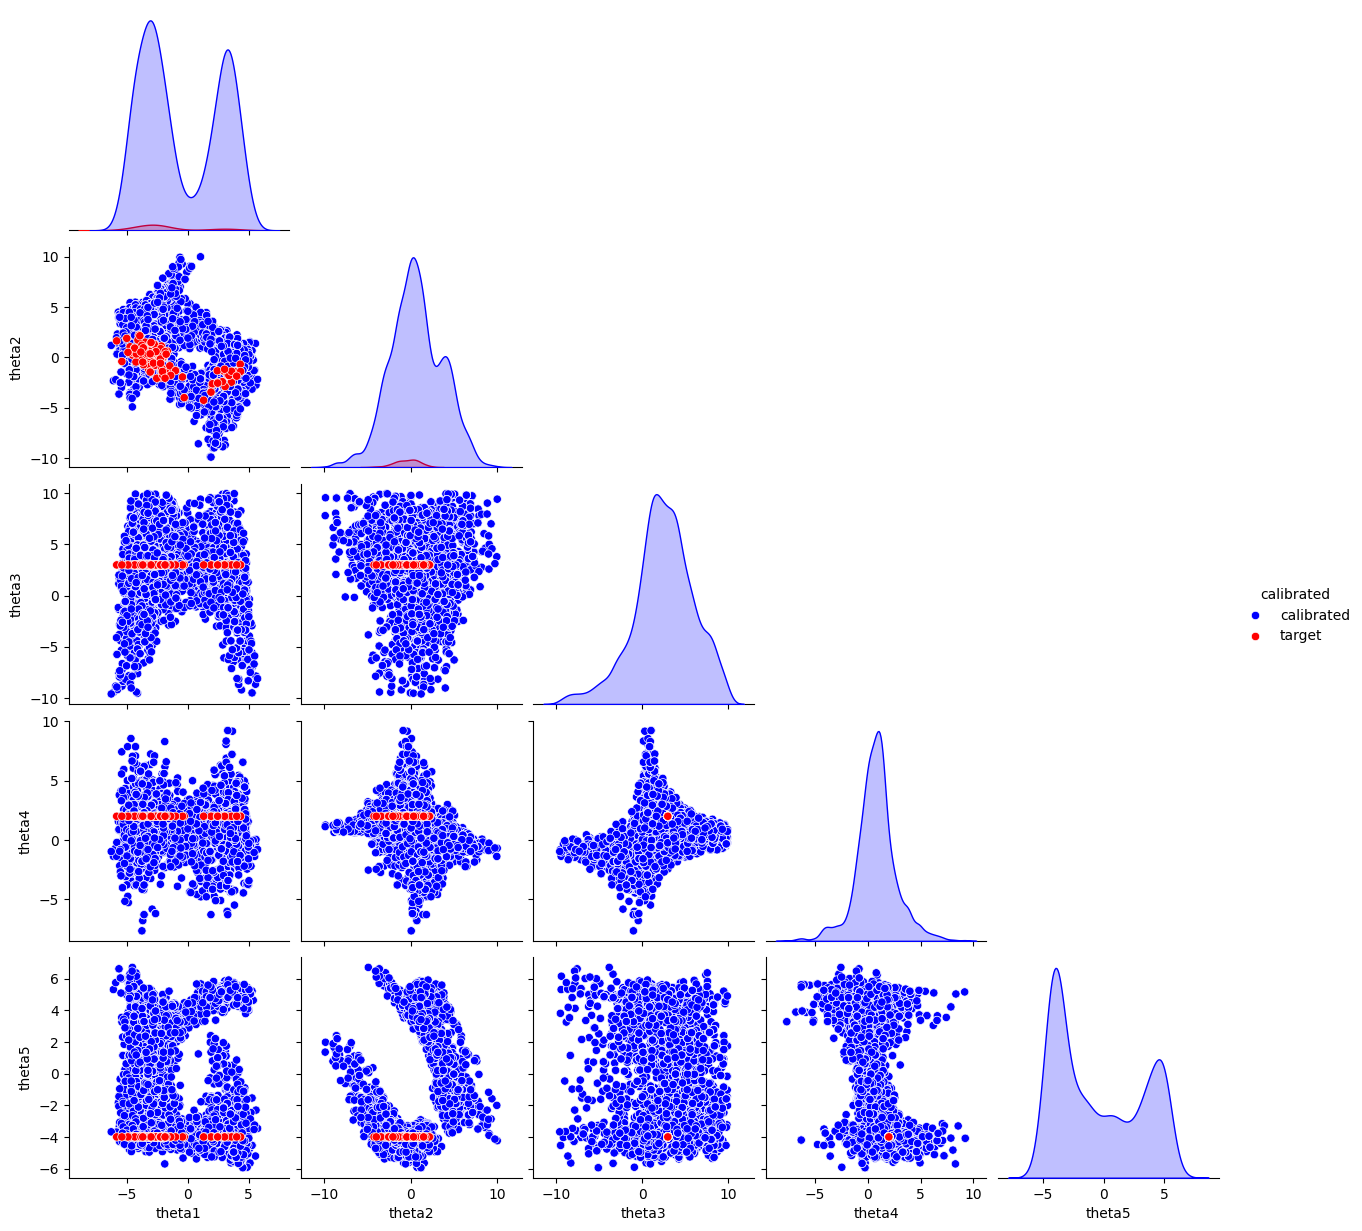

In [122]:
# Pairplot
sns.pairplot(
    df_full,
    hue="calibrated",
    corner=True,
    diag_kind="kde",
    palette={"calibrated": "blue", "target": "red"}
)
plt.show()
